In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # normalize mean = 0.5, var = 0.5
])

train_dataset = torchvision.datasets.MNIST(root='./data', train = True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


In [3]:
class Generator(nn.Module) :
    def __init__(self, noise_dim, img_dim) :
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=noise_dim, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=img_dim),
            nn.Tanh() # we normalize the images to [-1, 1]
        )

    def forward(self, z) :
        return self.model(z)

class Discriminator(nn.Module) :
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=img_dim, out_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid() # outputs a prob b/w 0 and 1
        )

    def forward(self, img) :
        return self.model(img)

In [15]:
class GeneratorCNN(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(GeneratorCNN, self).__init__()
        self.init_size = 7  # final image size is 28x28
        self.fc = nn.Linear(noise_dim, 128 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),     # 28x28
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img.view(out.size(0), -1)  # flatten to (batch_size, img_dim)

class DiscriminatorCNN(nn.Module):
    def __init__(self, img_dim):
        super(DiscriminatorCNN, self).__init__()
        self.img_dim = img_dim

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.size(0), 1, 28, 28)  # reshape flat image to (1, 28, 28)
        features = self.model(img)
        validity = self.classifier(features)
        return validity

In [18]:
noise_dim = 100
img_dim = 28*28

generator = Generator(noise_dim=noise_dim, img_dim=img_dim).to(device)
discriminator = Discriminator(img_dim=img_dim).to(device)

generator_cnn = GeneratorCNN(noise_dim=noise_dim, img_dim=img_dim).to(device)
discriminator_cnn = DiscriminatorCNN(img_dim=img_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)

g_cnn_optimizer = optim.Adam(generator_cnn.parameters(), lr = 0.0002)
d_cnn_optimizer = optim.Adam(discriminator_cnn.parameters(), lr = 0.0002)

criterion = nn.BCELoss()

def show_generate_image(epoch, generator, fixed_noise) :
    generator.eval()
    with torch.no_grad() :
        fake_images = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_images = fake_images * 0.5 * 0.5

    grid = torchvision.utils.make_grid(fake_images, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Generator imgs at epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()

def train_gen(
        train_loader, num_epochs,
        generator = generator,
        discriminator = discriminator,
        d_optimizer = d_optimizer,
        g_optimizer = g_optimizer,
        mode='one_one'
    ) :
    fixed_noise = torch.randn(64, noise_dim).to(device)

    for epoch in range(num_epochs) :
        for batch_idx, (real, _) in enumerate(train_loader):
            batch_size = real.size(0)
            real = real.view(batch_size, -1).to(device)

            # create real and fake labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            #? ============================
            #?  1. Train discriminator
            #? ============================

            # real img
            outputs = discriminator(real)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # fake img
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # total loss
            d_loss = d_loss_real + d_loss_fake

            discriminator.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #? ============================
            #? 2. Train generator
            #? ============================
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake)


            g_loss = criterion(outputs, real_labels)

            generator.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            #? ============================
            #? 3. modify according to mode
            #? ============================

            if mode == "five_gen_one_disc" :
                for _ in range(4):
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake)
                    g_loss = criterion(outputs, real_labels)

                    generator.zero_grad()
                    g_loss.backward()
                    g_optimizer.step()

            if mode == "five_disc_one_gen" :
                for _ in range(4) :
                    outputs = discriminator(real)
                    d_loss_real = criterion(outputs, real_labels)

                    # fake img
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake.detach())
                    d_loss_fake = criterion(outputs, fake_labels)

                    # total loss
                    d_loss = d_loss_real + d_loss_fake

                    discriminator.zero_grad()
                    d_loss.backward()
                    d_optimizer.step()


        if (epoch+1)%10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            show_generate_image(epoch+1, generator, fixed_noise)

cuda
Training: 1-step Gen, 1-step Disc


Epoch [10/150], D_loss: 0.7450, G_loss: 2.1008


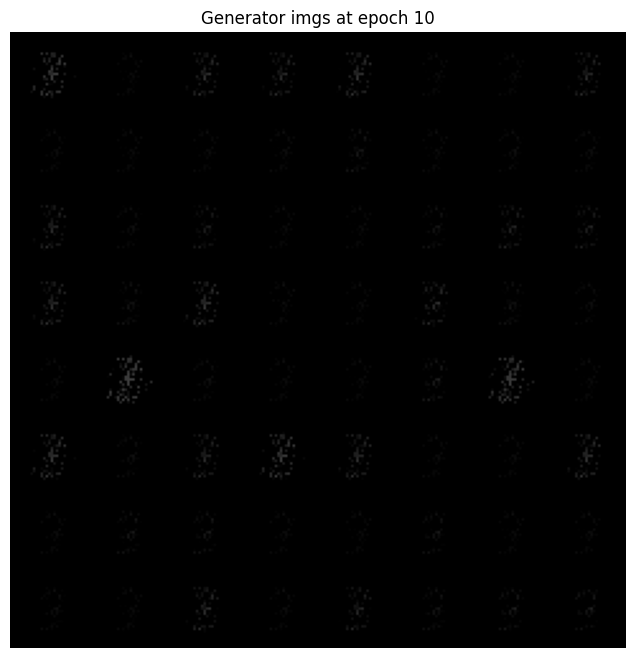

Epoch [20/150], D_loss: 0.2030, G_loss: 4.7465


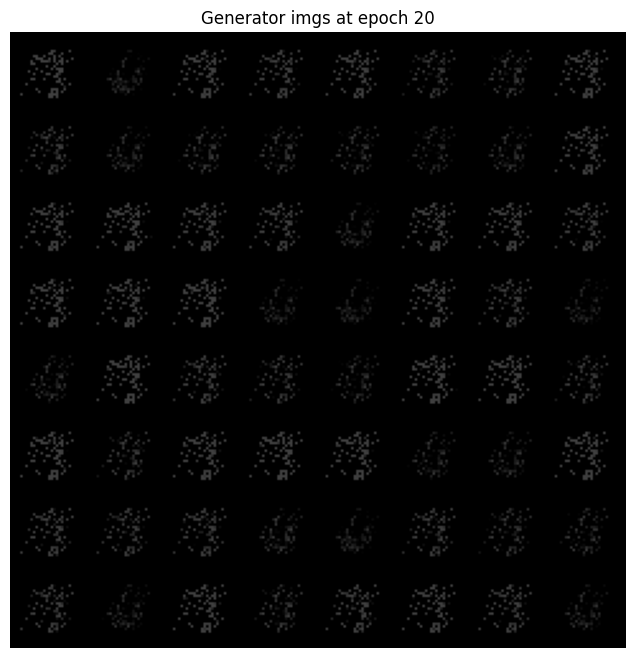

Epoch [30/150], D_loss: 0.1790, G_loss: 4.3727


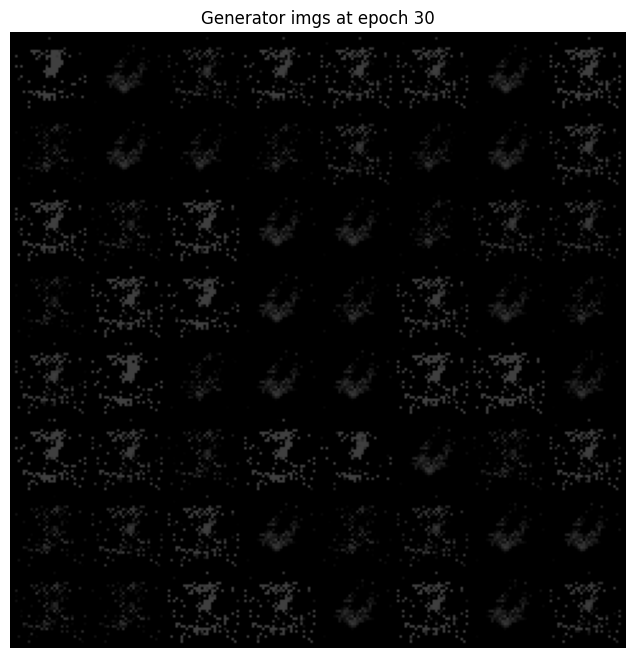

Epoch [40/150], D_loss: 0.3281, G_loss: 4.1411


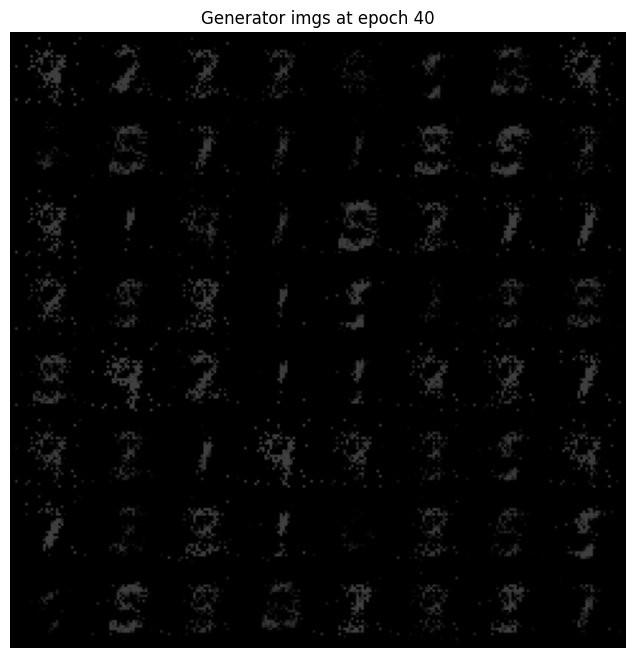

Epoch [50/150], D_loss: 0.4652, G_loss: 3.0555


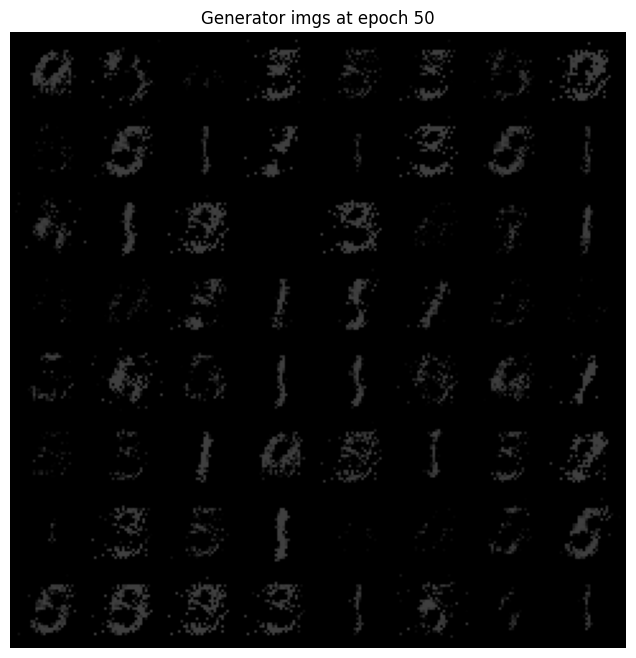

Epoch [60/150], D_loss: 0.7324, G_loss: 2.5113


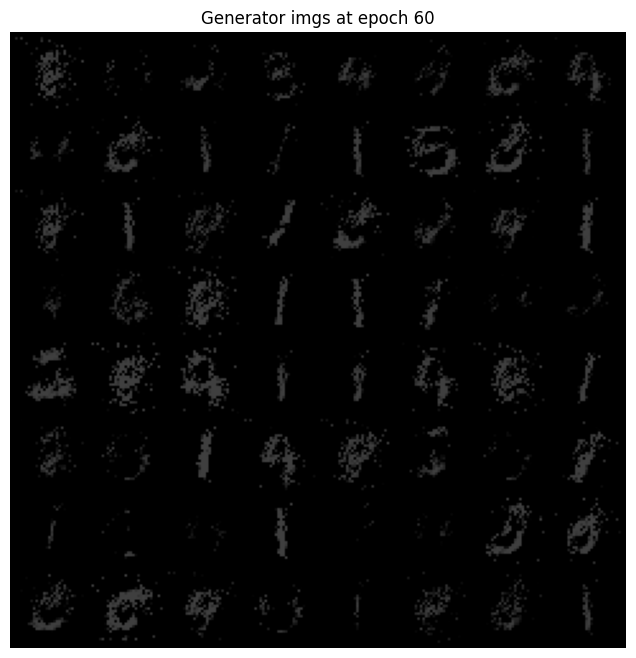

Epoch [70/150], D_loss: 0.5752, G_loss: 2.3053


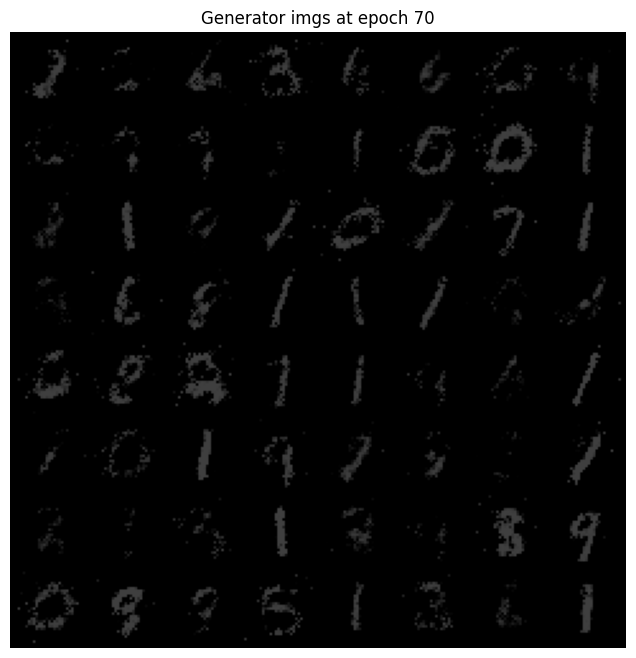

Epoch [80/150], D_loss: 0.8242, G_loss: 2.3663


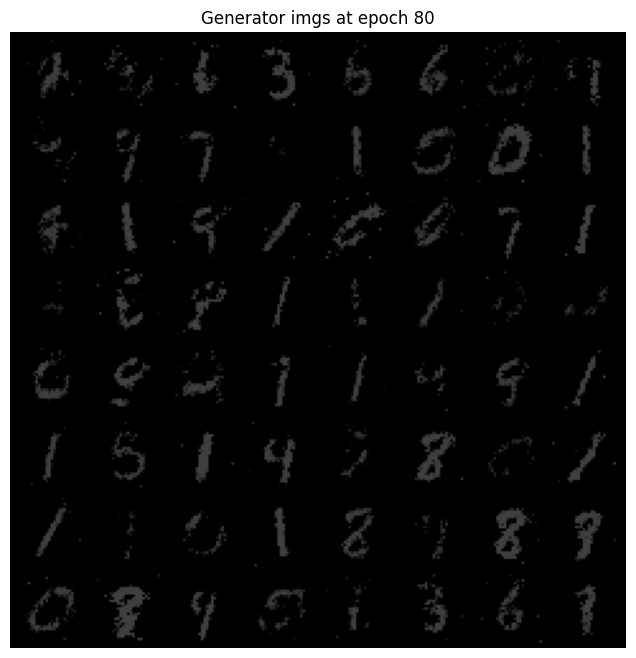

Epoch [90/150], D_loss: 0.9353, G_loss: 1.5005


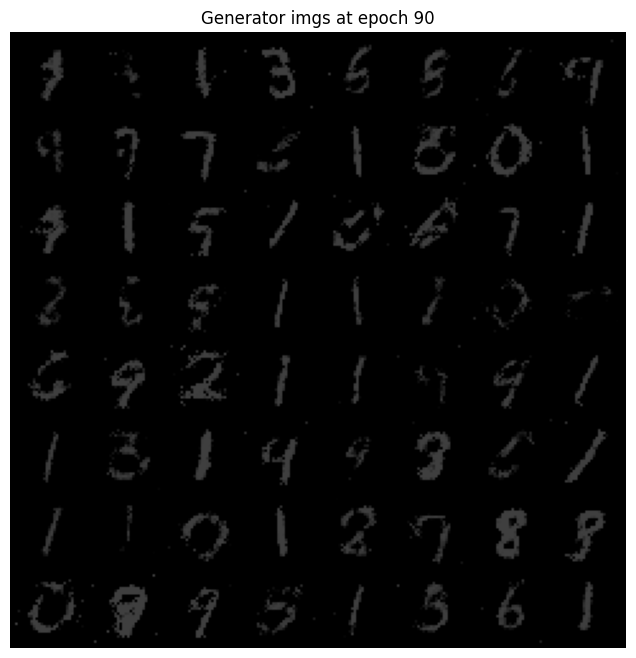

Epoch [100/150], D_loss: 0.8791, G_loss: 1.9500


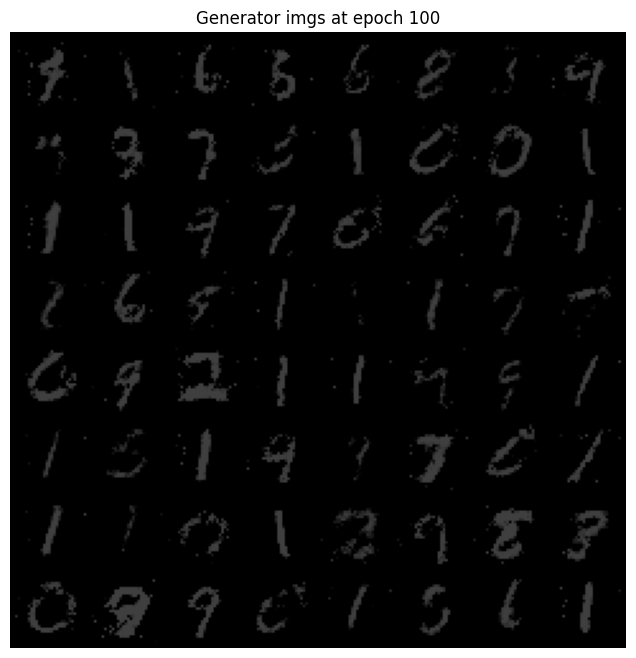

Epoch [110/150], D_loss: 0.8355, G_loss: 1.4721


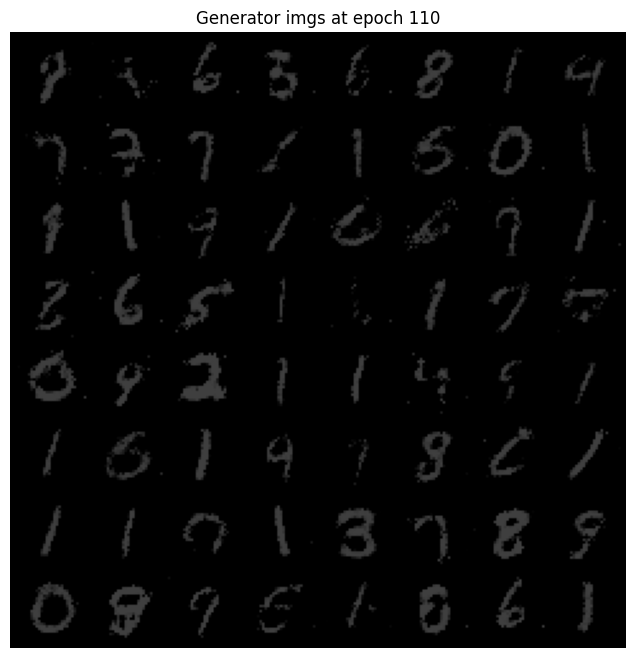

Epoch [120/150], D_loss: 0.9484, G_loss: 1.2277


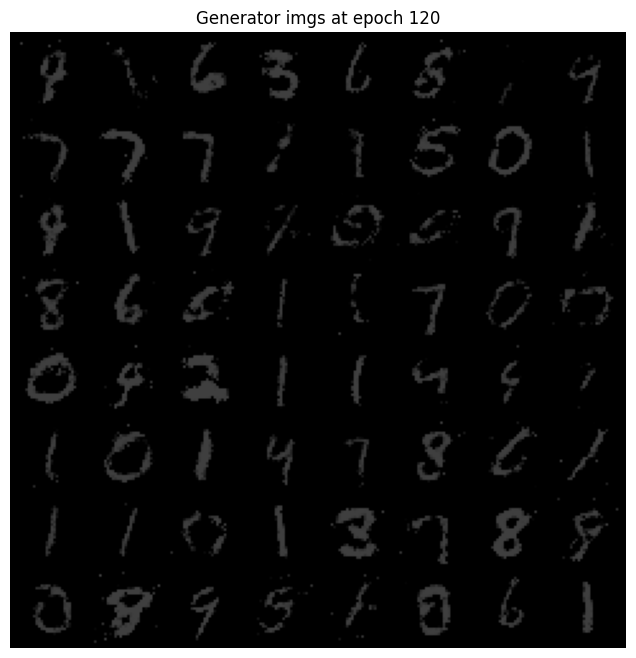

Epoch [130/150], D_loss: 0.9732, G_loss: 1.3989


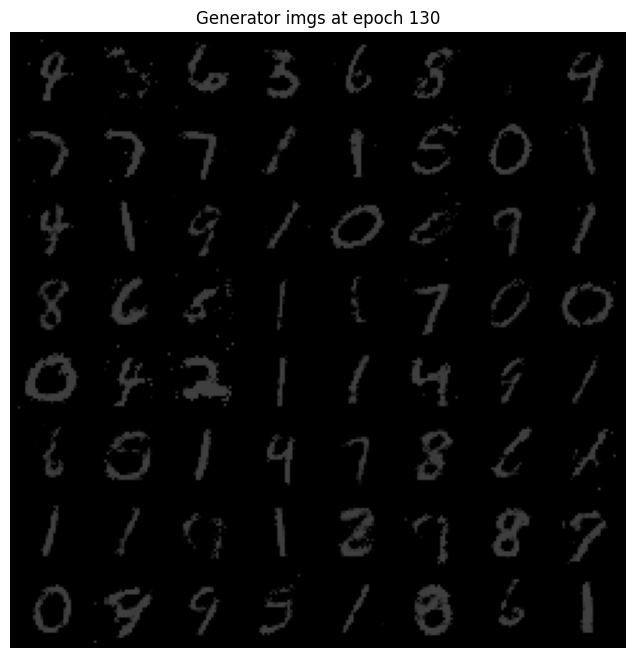

Epoch [140/150], D_loss: 0.9747, G_loss: 1.2670


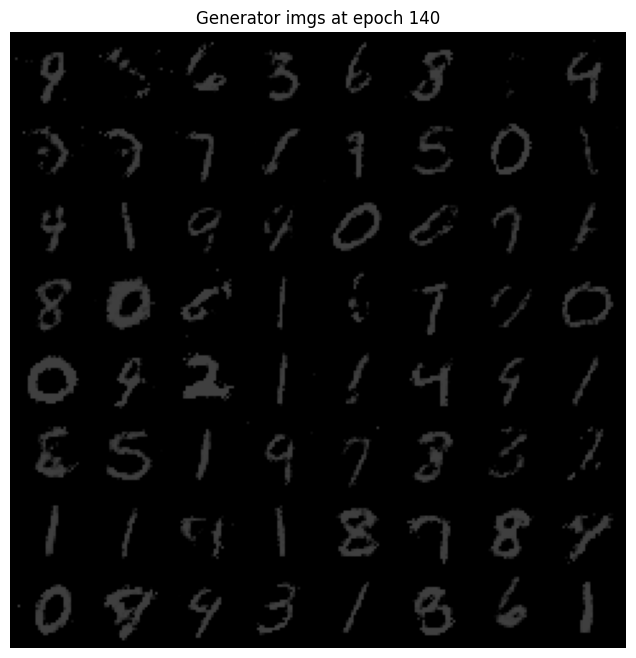

Epoch [150/150], D_loss: 1.0096, G_loss: 1.2358


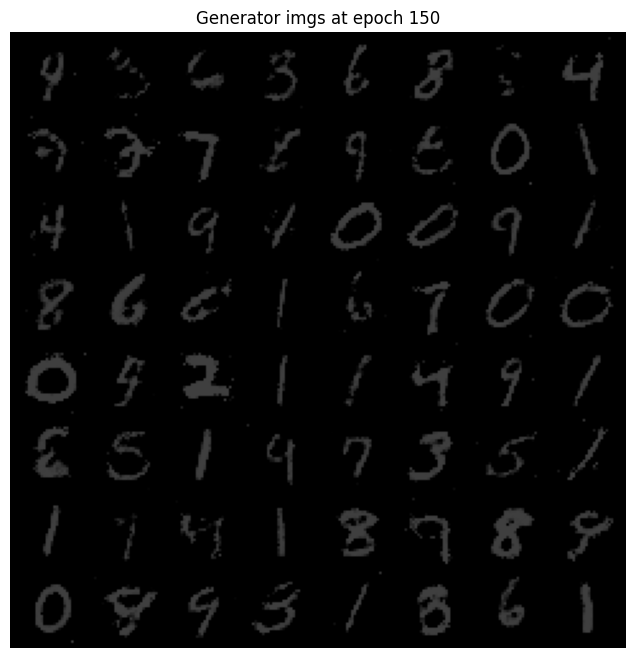

In [2]:
print("Training: 1-step Gen, 1-step Disc")
train_gen(train_loader, num_epochs=150, mode="one_one")

Training: 5-step Gen, 1-step Disc


Epoch [10/100], D_loss: 0.0001, G_loss: 10.7309


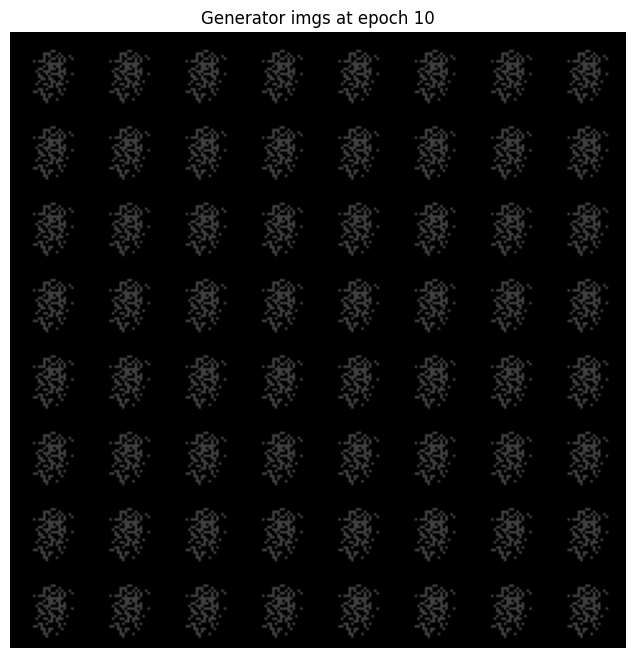

Epoch [20/100], D_loss: 0.0000, G_loss: 14.0073


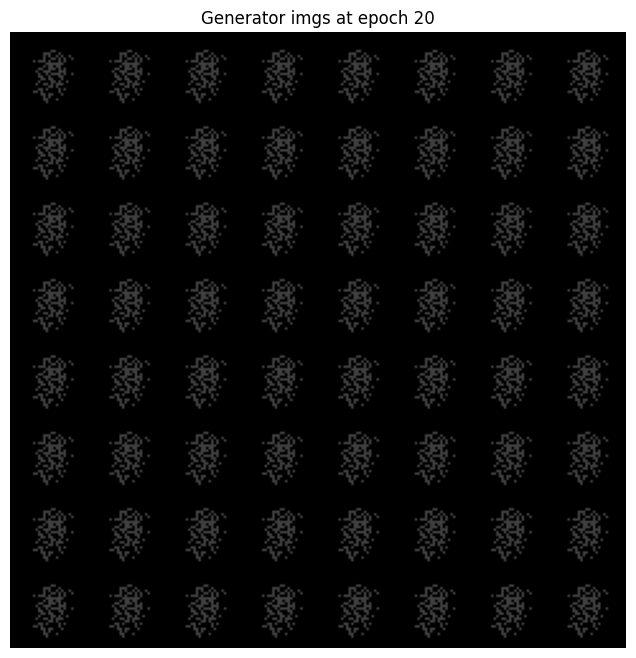

Epoch [30/100], D_loss: 0.0000, G_loss: 16.7437


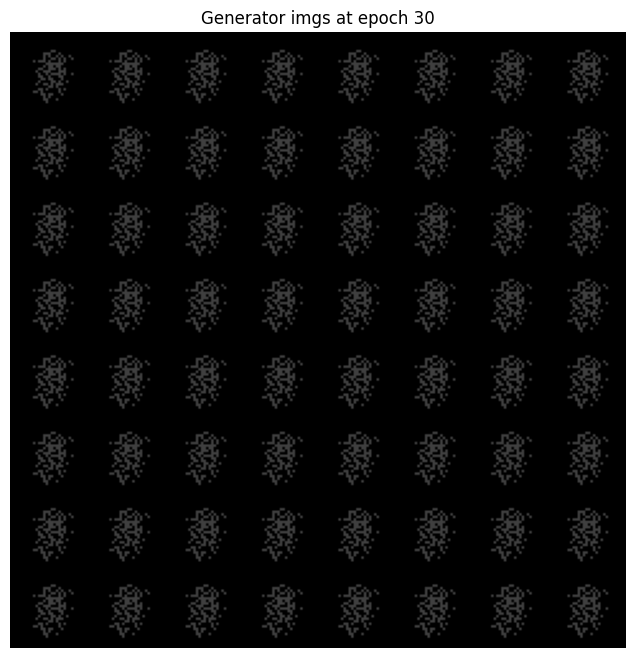

Epoch [40/100], D_loss: 0.0000, G_loss: 19.4133


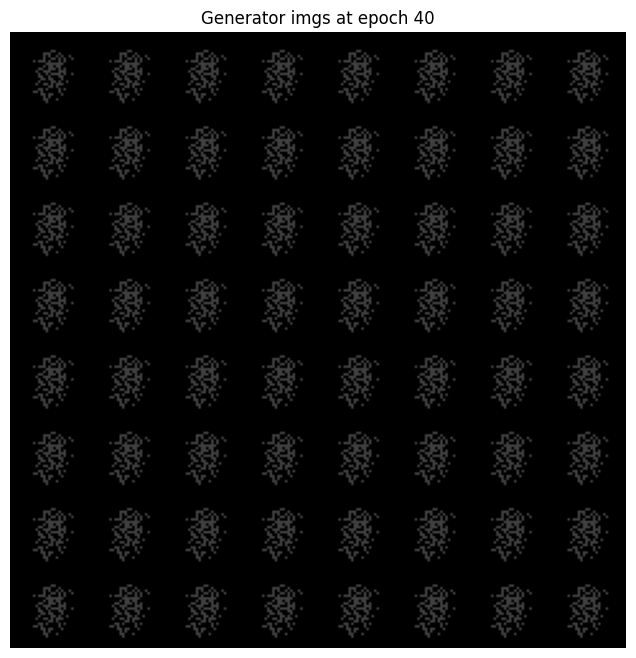

Epoch [50/100], D_loss: 0.0000, G_loss: 21.8766


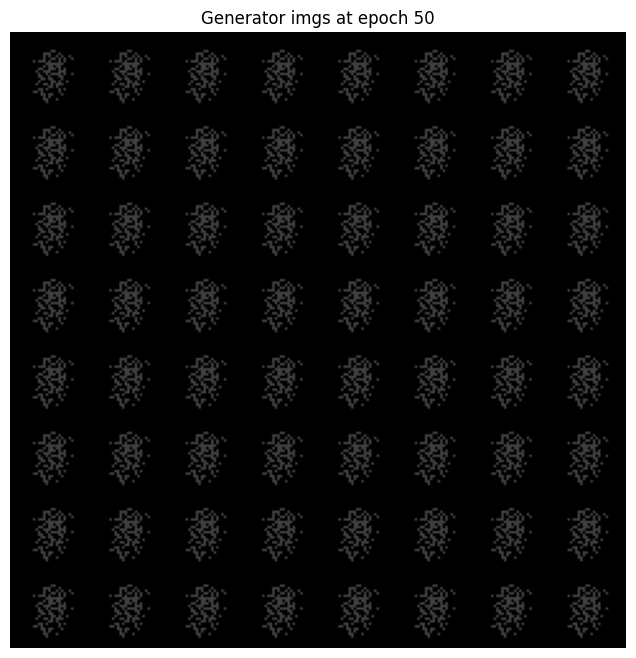

Epoch [60/100], D_loss: 0.0000, G_loss: 23.8210


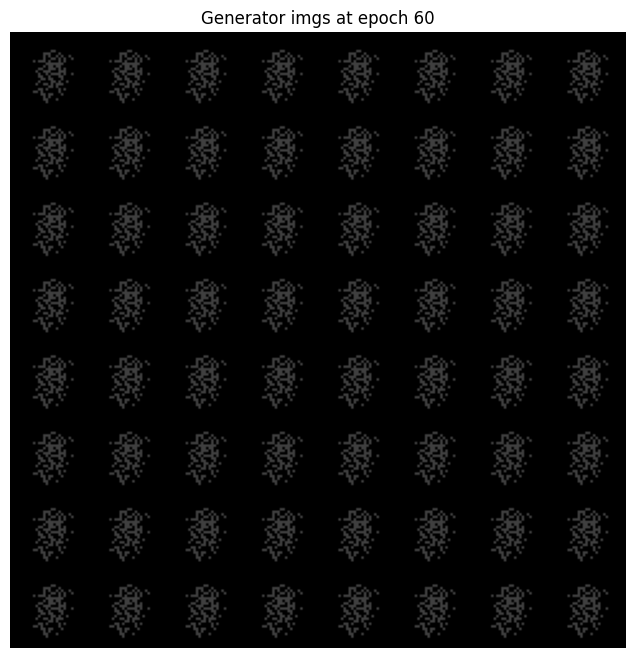

Epoch [70/100], D_loss: 0.0000, G_loss: 25.4635


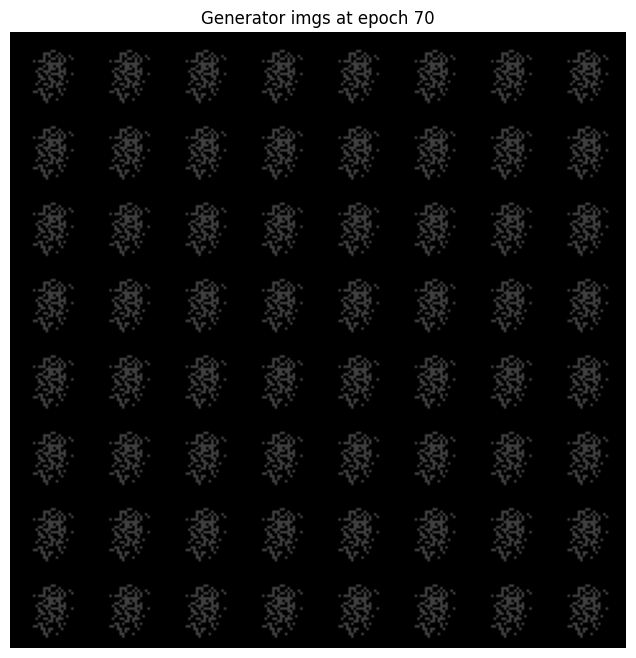

Epoch [80/100], D_loss: 0.0000, G_loss: 26.8077


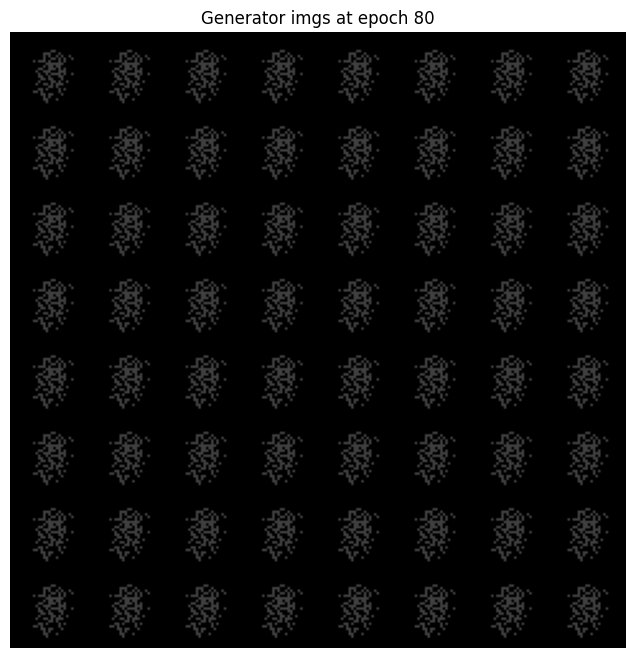

Epoch [90/100], D_loss: 0.0000, G_loss: 27.7481


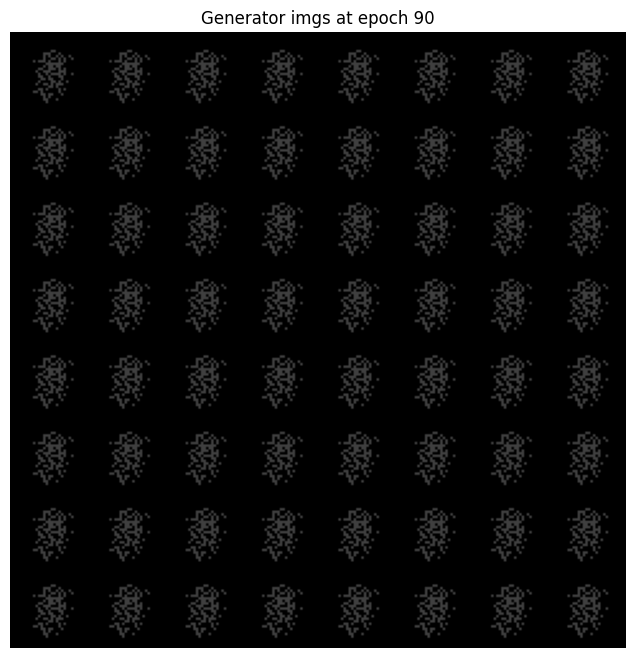

Epoch [100/100], D_loss: 0.0000, G_loss: 28.1496


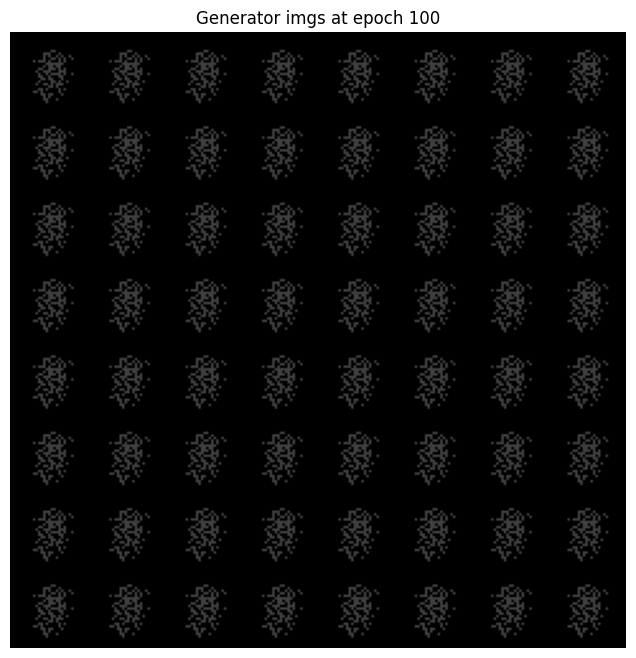

In [5]:
print("Training: 5-step Gen, 1-step Disc")
train_gen(train_loader, num_epochs=100, mode="five_gen_one_disc")

Training: 1-step Gen, 5-step Disc


Epoch [10/100], D_loss: 0.0000, G_loss: 28.7756


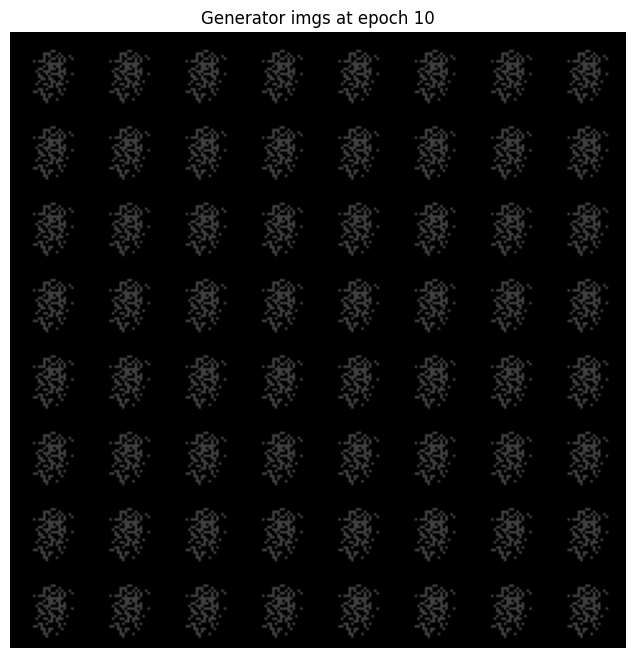

Epoch [20/100], D_loss: 0.0000, G_loss: 29.0445


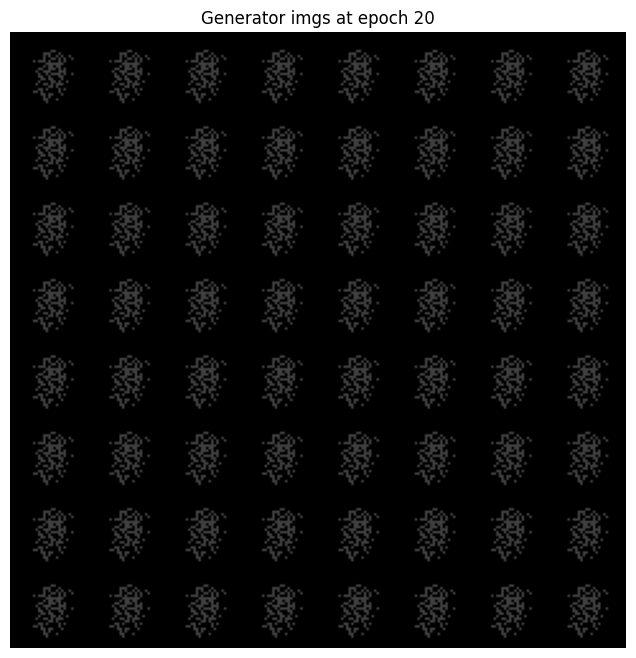

Epoch [30/100], D_loss: 0.0000, G_loss: 29.2161


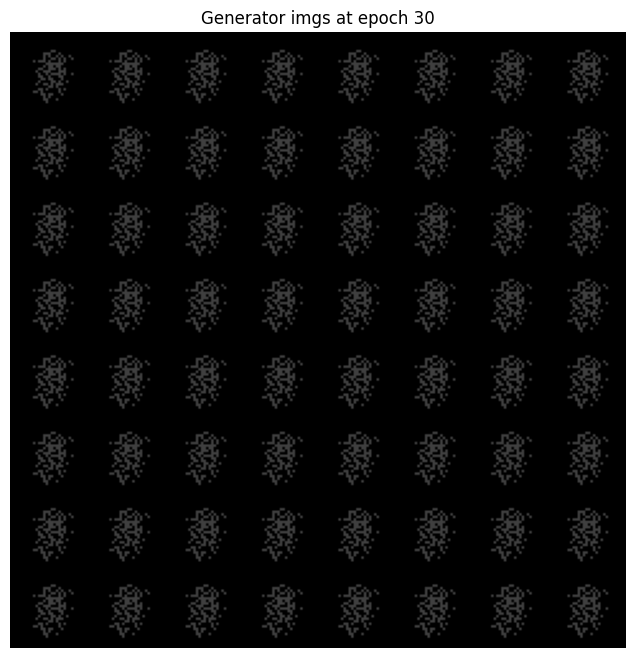

Epoch [40/100], D_loss: 0.0000, G_loss: 29.3389


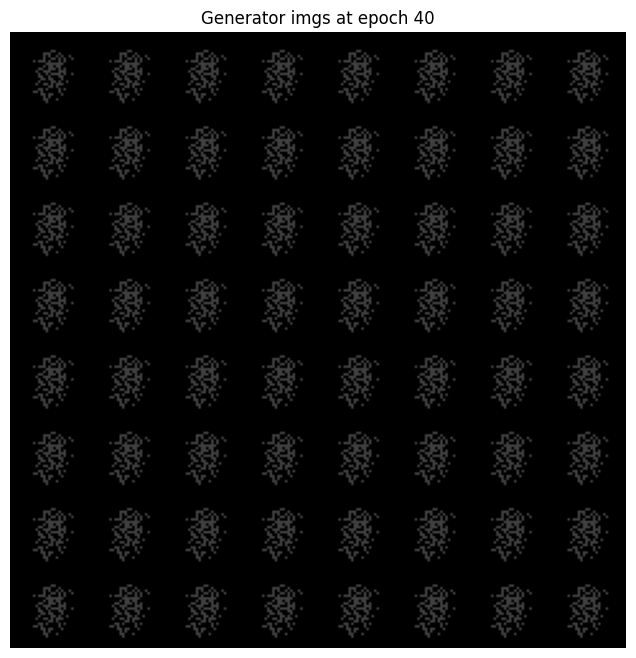

Epoch [50/100], D_loss: 0.0000, G_loss: 29.4377


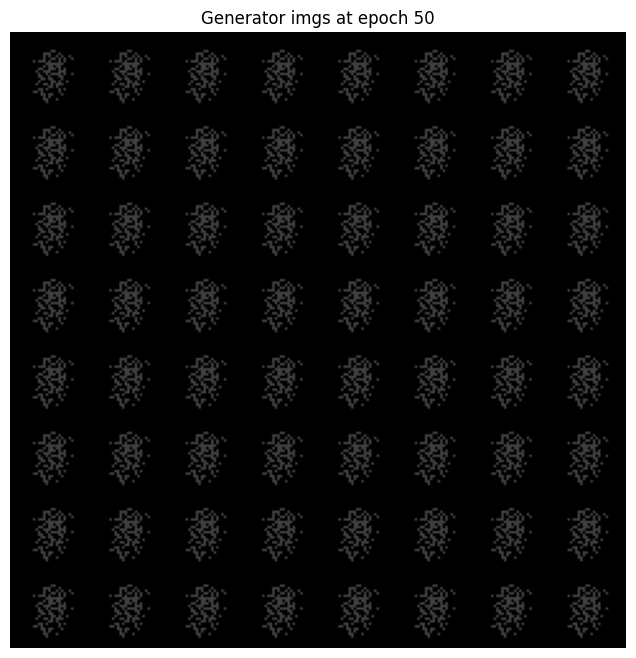

Epoch [60/100], D_loss: 0.0000, G_loss: 29.5240


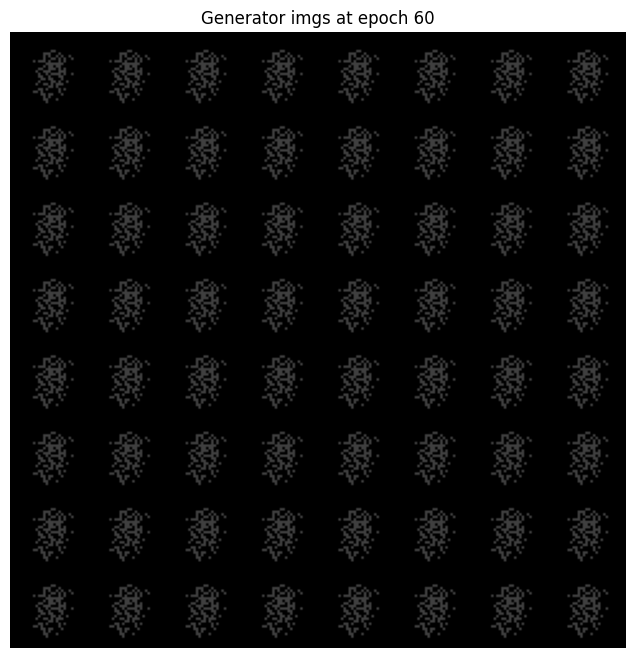

Epoch [70/100], D_loss: 0.0000, G_loss: 29.5988


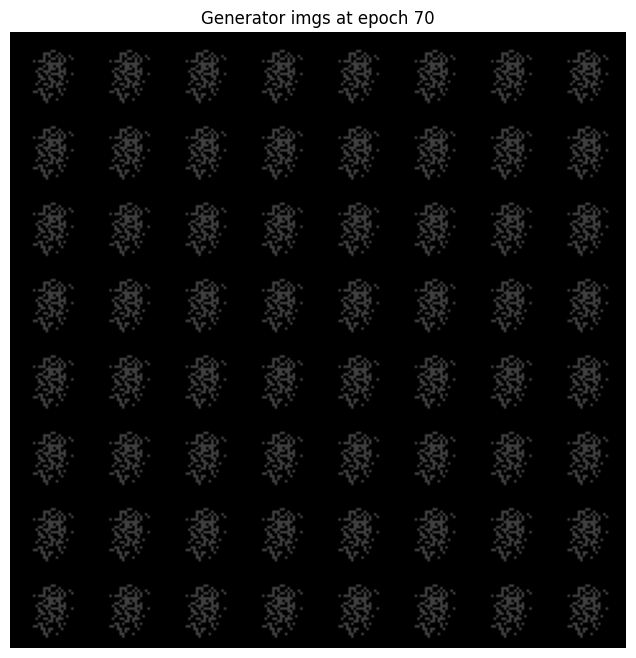

Epoch [80/100], D_loss: 0.0000, G_loss: 29.6653


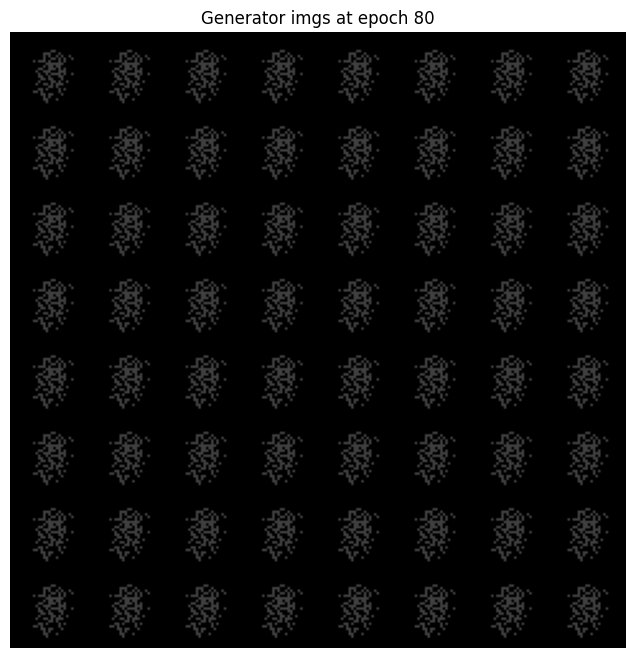

Epoch [90/100], D_loss: 0.0000, G_loss: 29.7266


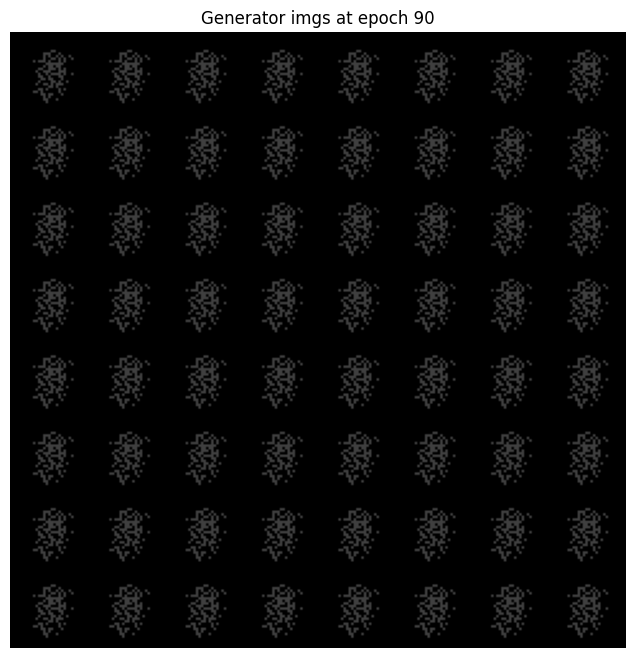

Epoch [100/100], D_loss: 0.0000, G_loss: 29.7801


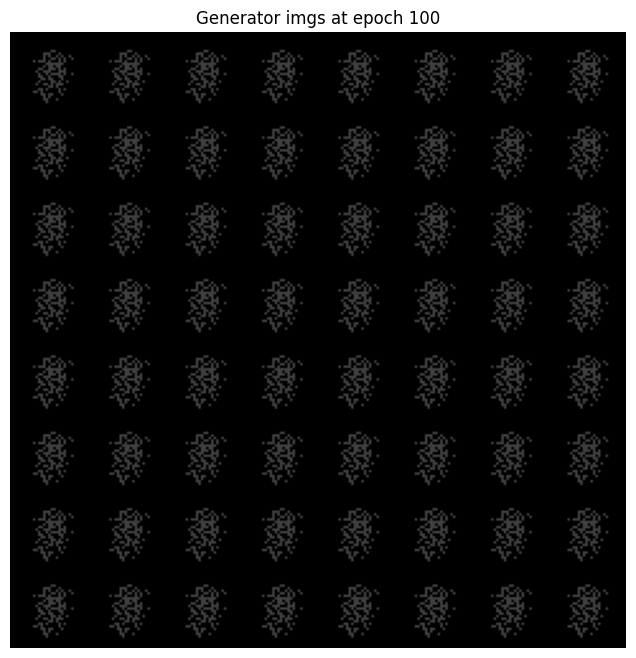

In [6]:
print("Training: 1-step Gen, 5-step Disc")
train_gen(train_loader, num_epochs=100, mode="five_disc_one_gen")

Training: 1-step Gen, 1-step Disc


Epoch [10/150], D_loss: 0.1504, G_loss: 3.8365


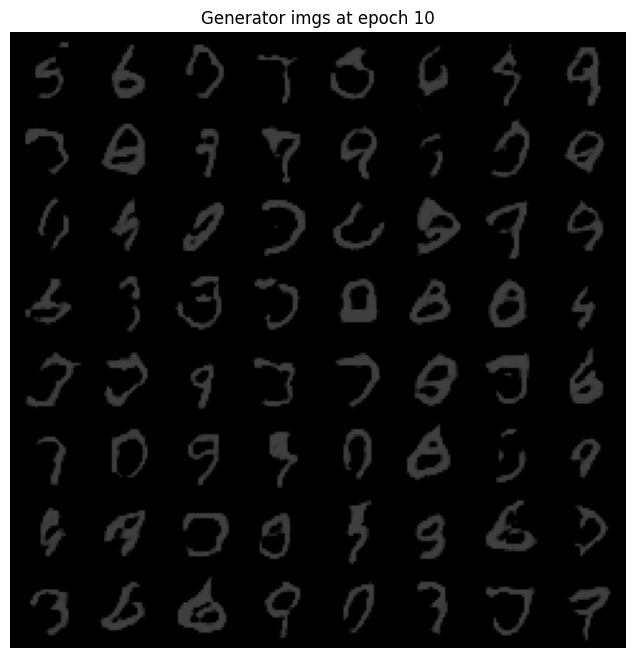

Epoch [20/150], D_loss: 0.1039, G_loss: 3.6419


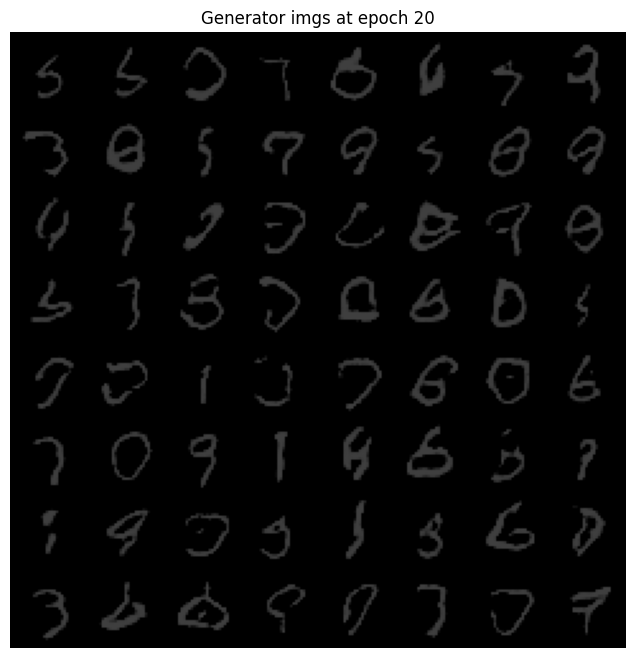

Epoch [30/150], D_loss: 0.1050, G_loss: 4.1045


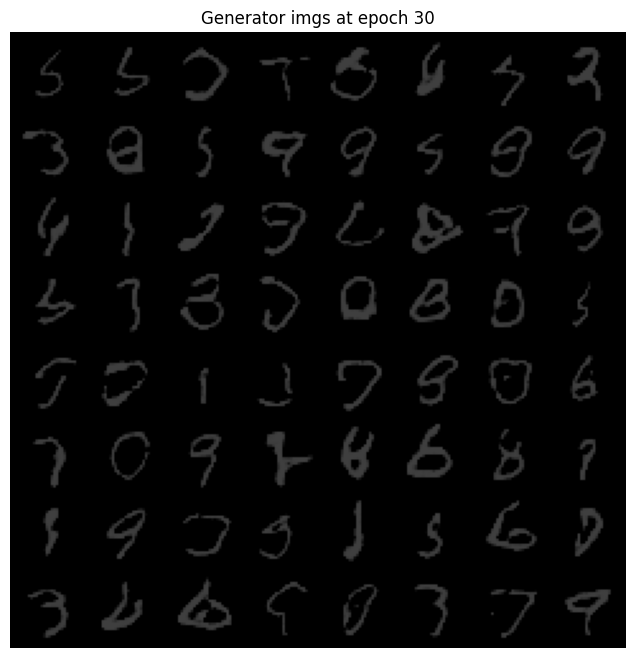

Epoch [40/150], D_loss: 0.1829, G_loss: 3.9457


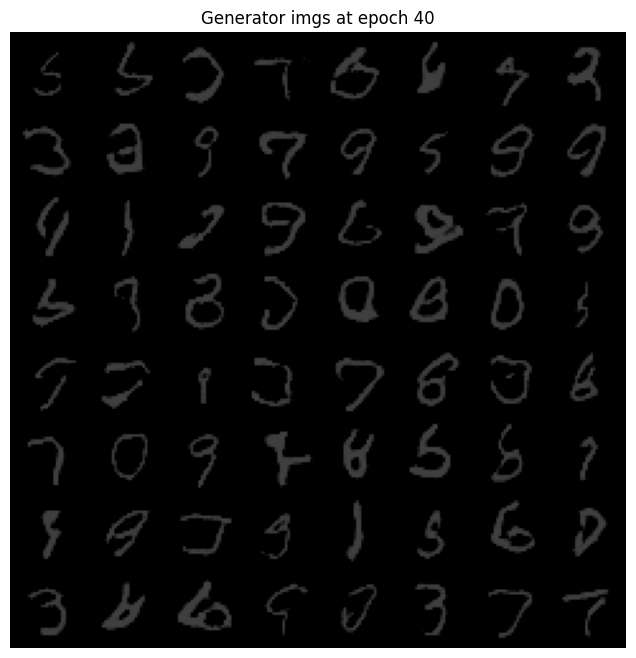

Epoch [50/150], D_loss: 0.1359, G_loss: 3.7008


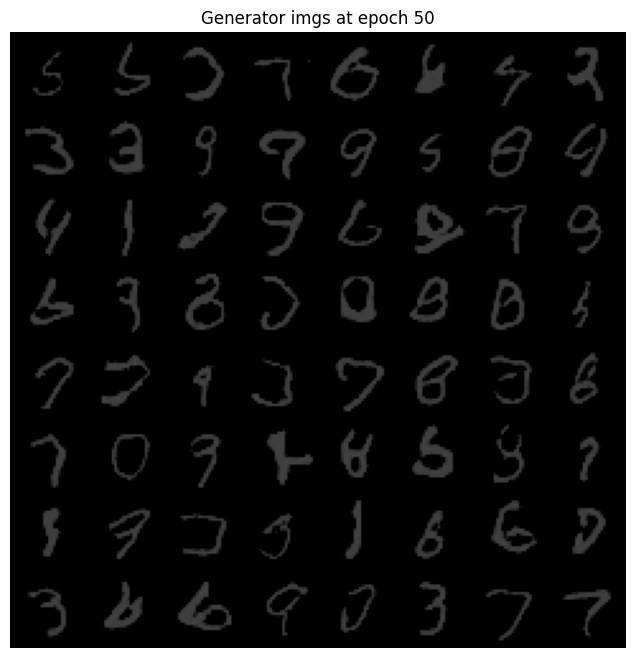

Epoch [60/150], D_loss: 0.1703, G_loss: 4.5218


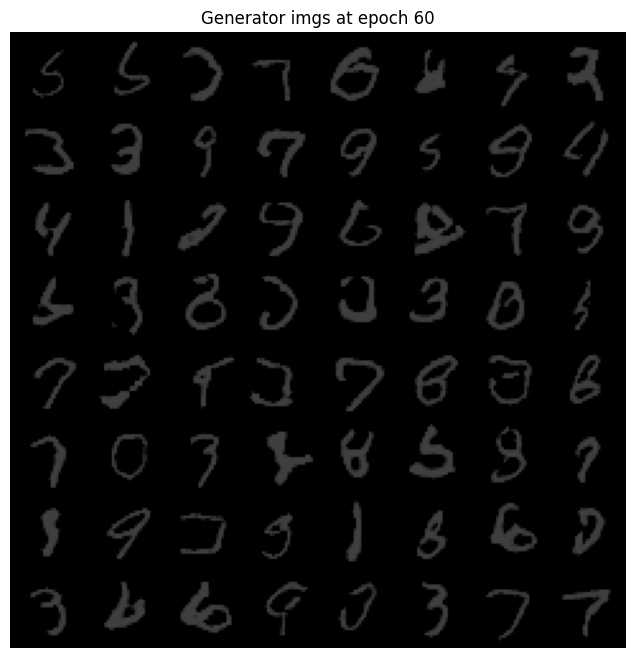

Epoch [70/150], D_loss: 0.1074, G_loss: 4.3514


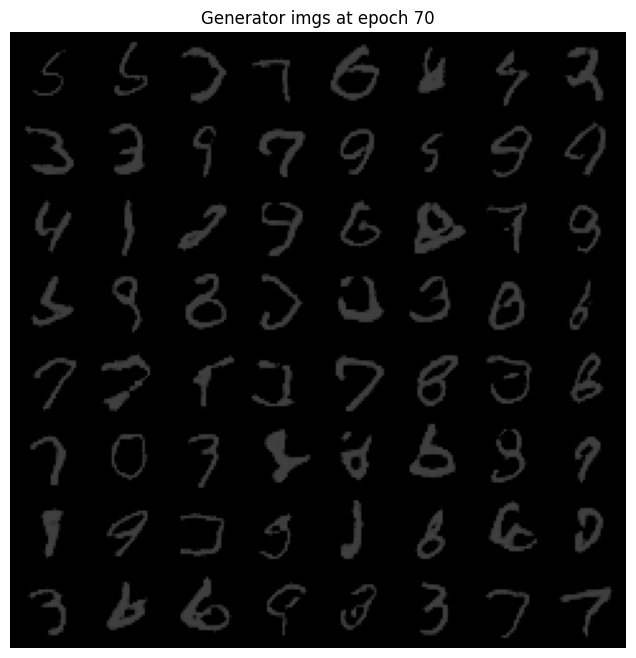

Epoch [80/150], D_loss: 0.0683, G_loss: 4.5439


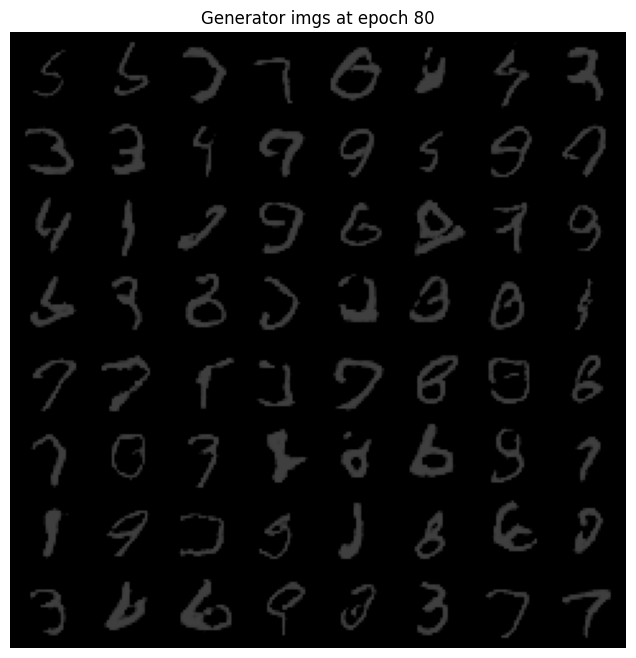

Epoch [90/150], D_loss: 0.0671, G_loss: 6.2239


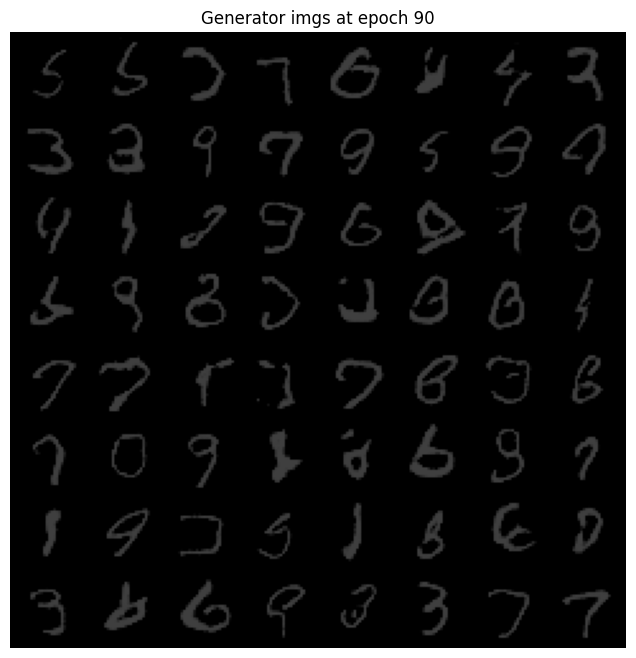

Epoch [100/150], D_loss: 0.0291, G_loss: 6.4634


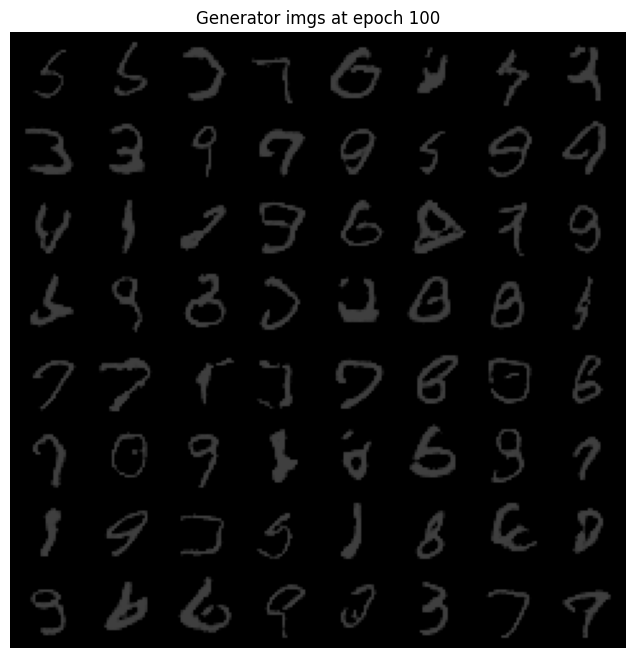

Epoch [110/150], D_loss: 0.0430, G_loss: 3.3365


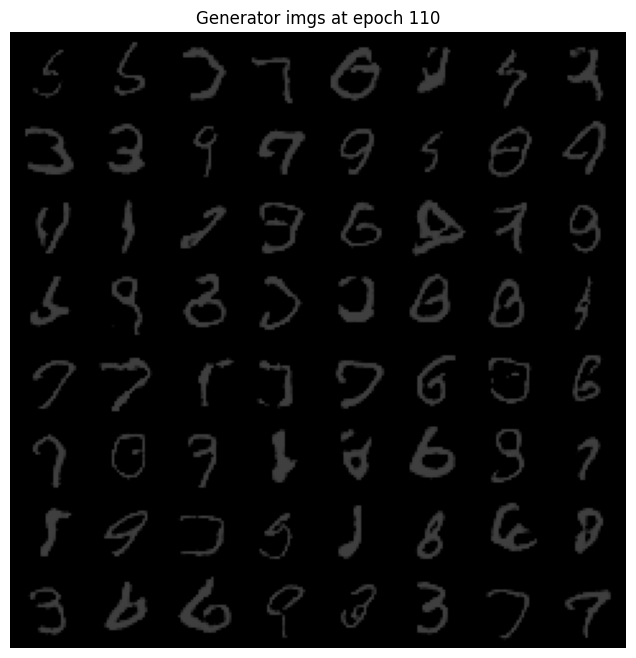

Epoch [120/150], D_loss: 0.0658, G_loss: 1.8390


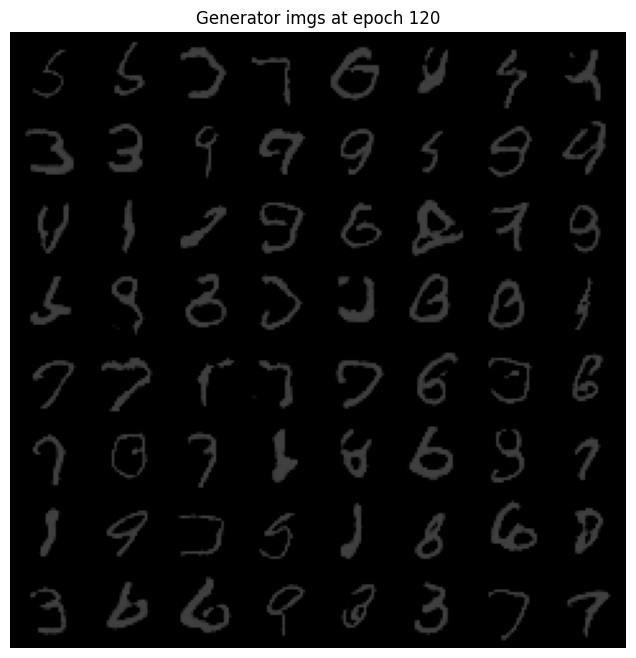

Epoch [130/150], D_loss: 0.0214, G_loss: 4.9774


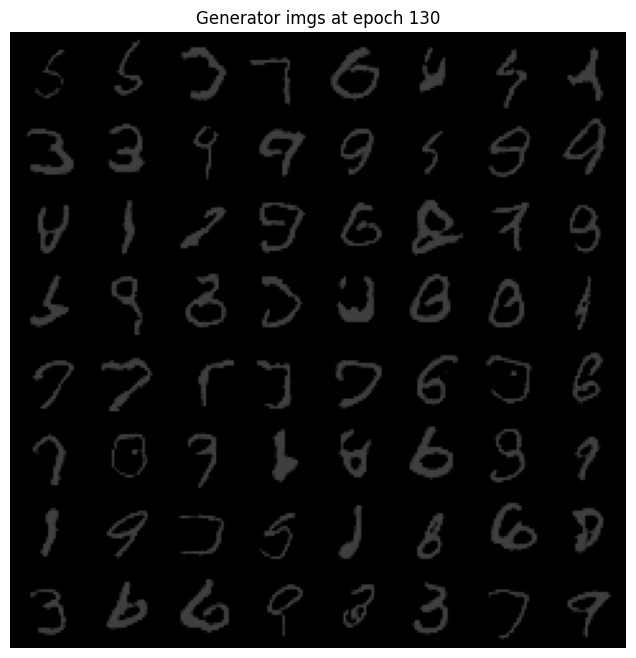

Epoch [140/150], D_loss: 0.0316, G_loss: 5.7261


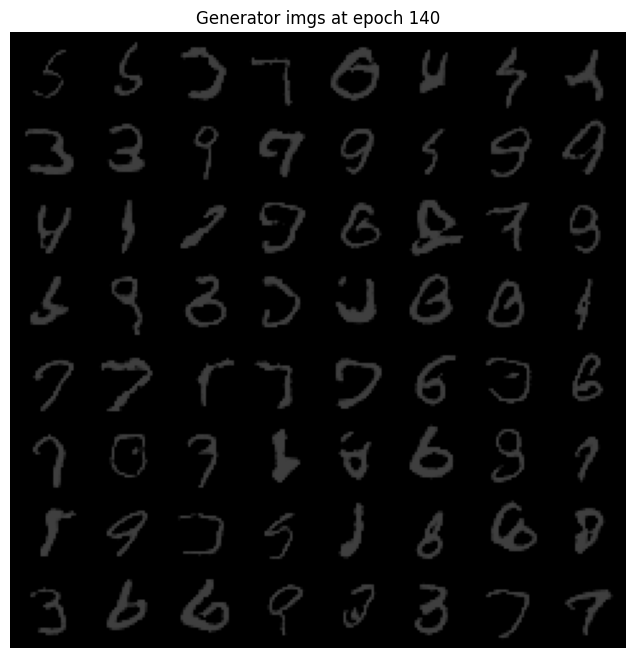

Epoch [150/150], D_loss: 0.0743, G_loss: 5.5277


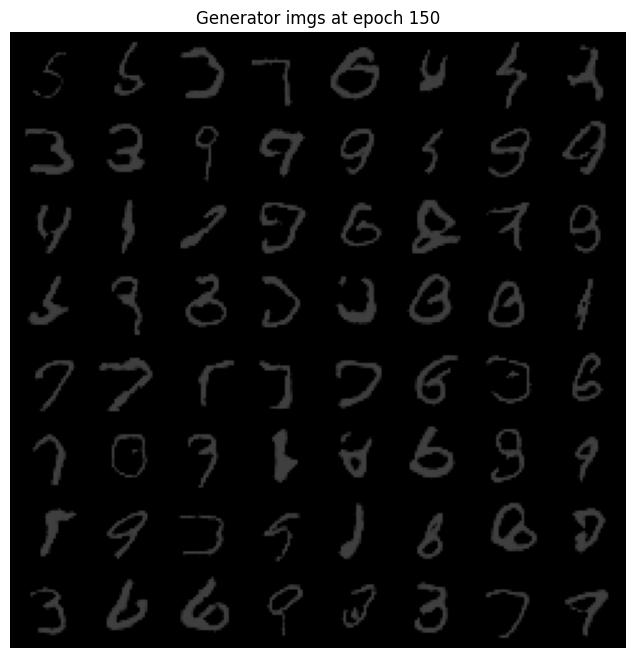

In [20]:
print("Training: 1-step Gen, 1-step Disc")
train_gen(
    train_loader, generator = generator_cnn,
    discriminator = discriminator_cnn,
    d_optimizer = d_cnn_optimizer,
    g_optimizer = g_cnn_optimizer,
    num_epochs=150, mode="one_one"
)